Jupyter notebooks are divided into cells that can contain [markdown](https://daringfireball.net/projects/markdown/) or code that you can run interactively from the notebook interface. You can progress through the cells in the notebook by clicking the play button 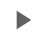 in the notebook tab's toolbar.

Click the play button to advance to the next cell and continue on in the lab.

This notebook works through the main steps that are shared by most machine learning projects:

- preparing data
- training a model
- hosting the model
- Using the hosted model for inference

You will use a built-in SageMaker algorithm for training the model as well as use SageMaker's model hosting capability to deploy the trained model. In this notebook you will work with US flight delay data to develop a model that can forecast flight delays.